In [10]:
import pandas as pd
import numpy as np
import glob
from tqdm.auto import tqdm
import itertools
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# compound package
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys
import pubchempy as pc
from padelpy import from_smiles, padeldescriptor

# protein package
from protlearn.preprocessing import remove_unnatural
from protlearn.features import aac
from protlearn.features import paac
from protlearn.features import aaindex1

In [3]:
# read interactions data
intera_df = pd.read_csv("dataset/interactions_df.csv")
intera_df

,uniprot_id,isomeric_smiles,can_smi,class
0,Q9UEE5,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,CNC1CC2OC(C)(C1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2...,1
1,Q9UEE5,CCN(CC)CCNC(=O)c1c(C)[nH]c(\C=C2/C(=O)Nc3ccc(F...,CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(F)c...,1
2,Q9UEE5,COc1ccc(cc1OC)-c1cnc2scc(NC(=O)C3CCCCC3)c2c1,COc1ccc(-c2cnc3scc(NC(=O)C4CCCCC4)c3c2)cc1OC,1
3,Q9UEE5,C[C@]12O[C@H](C[C@]1(O)CO)n1c3ccccc3c3c4C(=O)N...,CC12OC(CC1(O)CO)n1c3ccccc3c3c4c(c5c6ccccc6n2c5...,1
4,Q9UEE5,O=C(N1CCNCC1)c1ccc(\C=C\c2n[nH]c3ccccc23)cc1,O=C(c1ccc(C=Cc2n[nH]c3ccccc23)cc1)N1CCNCC1,1
...,...,...,...,...
268342,P11309,CO[C@H]1\C=C\C[C@H](C)C[S@@](=O)(NC(=O)c2cnc(O...,COc1ncc(C(=O)NS2(=O)=NC(=O)c3ccc4c(c3)N(CC3CCC...,0
268343,P12931,[H][C@@]1(CC[C@@H](CC1)N1CC(C1)OC(F)F)[C@@H](C...,CSc1cc(C)[nH]c(=O)c1CNC(=O)c1c(C)n(C(C)C2CCC(N...,0
268344,Q9NZQ7,[#6]\[#6](-[#6])=[#6]\[#6]-c1c(-[#8])cc(-[#8])...,[C]C([C])=[C][C]c1c([O])cc([O])c2c(=O)cc(-c3cc...,0
268345,Q06187,Nc1nccn2c(nc(-c3ccc(cc3)C(O)(C(F)F)c3cccc(c3)C...,Nc1nccn2c(C3CCC4CCC(=O)N4C3)nc(-c3ccc(C(O)(c4c...,0


# Sampling

**All data will be sampled into 10 groups with 10k samples each group**

In [32]:
def get_random_samples(df, n_groups, n_samples):
    
    samples = []
    
    for i in tqdm(range(n_groups)):
        
        tmp = df.sample(n=n_samples, random_state=40+i)
        
        tmp.reset_index(drop=True, inplace=True)
        
        samples.append(tmp)
        
    return samples

In [33]:
sampled = get_random_samples(intera_df, 10, 10000)
sampled[0]

  0%|          | 0/10 [00:00<?, ?it/s]

,uniprot_id,isomeric_smiles,can_smi,class
0,P11309,Cc1nc2cccc(-c3cc4c(CCNC4=O)[nH]3)c2nc1N[C@@H]1...,Cc1nc2cccc(-c3cc4c([nH]3)CCNC4=O)c2nc1NC1CC(O)C1,1
1,P28482,CN1CC[C@@H]1C(=O)N1CC[C@@](C)(C1)N1CCc2c1nc(nc...,CN1CCC1C(=O)N1CCC(C)(N2CCc3c(-c4cnc(N)nc4)nc(N...,0
2,P24385,CS(=O)(=O)N1CCC(CC1)N1CC(CC#N)(C1)n1cc(cn1)-c1...,CS(=O)(=O)N1CCC(N2CC(CC#N)(n3cc(-c4ccnc5[nH]cc...,0
3,P42338,COc1ncc-2cc1NS(=O)(=O)c1ccc(F)c(c1)C(=O)NCc1cc...,COc1ncc2cc1NS(=O)(=O)c1ccc(F)c(c1)C(=O)NCc1ccc...,1
4,O60674,NC(=O)c1cn(nc1Nc1ccc(cc1)C#N)[C@H]1COCC[C@@H]1C#N,N#Cc1ccc(Nc2nn(C3COCCC3C#N)cc2C(N)=O)cc1,1
...,...,...,...,...
9995,Q07343,COc1ccc(-c2nc(C(=O)N3CCC(O)(CC3)c3ccccc3)c(CN)...,COc1ccc(-c2nc(C(=O)N3CCC(O)(c4ccccc4)CC3)c(CN)...,1
9996,P03372,CN([C@@H]1CCN(C1)c1ncnc2[nH]ccc12)c1ncc(cc1[N+...,CN(c1ncc(C#N)cc1[N+](=O)[O-])C1CCN(c2ncnc3[nH]...,0
9997,P12931,COc1cc(Nc2c(cnc3cc(sc23)-c2csc(CN3CCN(C)CC3)c2...,COc1cc(Nc2c(C#N)cnc3cc(-c4csc(CN5CCN(C)CC5)c4)...,1
9998,P36897,CC(C)OC(=O)N1CCC(C1)c1cc(Nc2ncc(s2)C(=O)Nc2c(C...,Cc1nc(Nc2ncc(C(=O)Nc3c(C)cccc3Cl)s2)cc(C2CCN(C...,0


/home/biofarmaka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


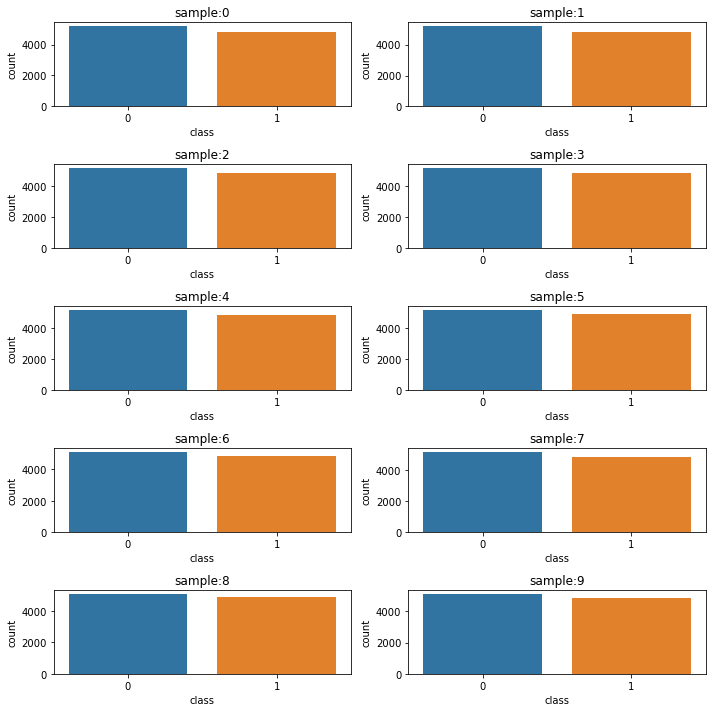

In [39]:
fig, ax = plt.subplots(5,2, figsize=(10,10))

for i in range(5):
    
    for j in range(2):
        
        sns.countplot(data=sampled[i*2+j], x="class", ax=ax[i,j])
        ax[i,j].set_title(f"sample:{i*2+j}")
        
fig.tight_layout()
fig.show()

# Compound Features

## SMILES Preparations

In [44]:
smiles_list = [sampled[i]["can_smi"].tolist() for i in range(10)]
len(smiles_list)

10

## ECFP

In [42]:
def calc_ecfp(list_of_smiles:list)->list:
    
    ecfp = []
    
    for smiles in tqdm(list_of_smiles):
        
        try:
        
            mol = Chem.MolFromSmiles(smiles)

            can = Chem.MolToSmiles(mol, isomericSmiles=False)

            mol = Chem.MolFromSmiles(can)

            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024, useFeatures=True)

            ecfp.append([int(x) for x in fp.ToBitString()])
            
        except:
            
            ecfp.append([np.NaN]*1024)
            
            print("error in smiles:", smiles)
        
    res = np.array([np.array(x) for x in ecfp])
        
    return res

In [47]:
ecfp_res = []

for i in range(10):
    
    ecfp_res.append(calc_ecfp(smiles_list[i]))
    

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [57]:
joblib.dump(ecfp_res,"dataset/phase3_ecfp.pkl")

['dataset/phase3_ecfp.pkl']

## Morgan

In [53]:
def calc_morgan(list_of_smiles:list)->list:
    
    morgan = []
    
    for smiles in tqdm(list_of_smiles):
        
        try:
        
            mol = Chem.MolFromSmiles(smiles)

            can = Chem.MolToSmiles(mol, isomericSmiles=False)

            mol = Chem.MolFromSmiles(can)

            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)

            morgan.append([int(x) for x in fp.ToBitString()])
            
        except:
            
            morgan.append([np.NaN]*1024)
            
            print("error in smiles:", smiles)
        
    res = np.array([np.array(x) for x in morgan])
        
    return res

In [54]:
morgan_res = []

for i in range(10):
    
    morgan_res.append(calc_morgan(smiles_list[i]))
    

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [58]:
joblib.dump(morgan_res, "dataset/phase3_morgan.pkl")

['dataset/phase3_morgan.pkl']

## MACCS

In [59]:
def calc_maccs(list_of_smiles:list)->np.array:
    
    maccs = []
    
    for smiles in tqdm(list_of_smiles):
        
        try:
        
            mol = Chem.MolFromSmiles(smiles)

            fp = MACCSkeys.GenMACCSKeys(mol)

            fp_arr = np.array(list(fp.ToBitString())).astype(int)

            maccs.append(fp_arr)
            
        except:
            
            maccs.append([np.NaN]*167)
            
            print("error in smiles: ", smiles)
        
    fp_array = np.array(maccs)
    
    return fp_array

In [60]:
maccs_res = []

for i in tqdm(range(10)):
    
    maccs_res.append(calc_maccs(smiles_list[i]))
    

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [61]:
joblib.dump(maccs_res, "dataset/phase3_maccs.pkl")

['dataset/phase3_maccs.pkl']

## PubChem

### PadelPy Preps

In [62]:
fp_path = "padelpy/"

xml_files = glob.glob(fp_path+"*.xml")
xml_files.sort()

FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2DCount': 'padelpy/AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'padelpy/AtomPairs2DFingerprinter.xml',
 'EState': 'padelpy/EStateFingerprinter.xml',
 'CDKextended': 'padelpy/ExtendedFingerprinter.xml',
 'CDK': 'padelpy/Fingerprinter.xml',
 'CDKgraphonly': 'padelpy/GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'padelpy/KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'padelpy/KlekotaRothFingerprinter.xml',
 'MACCS': 'padelpy/MACCSFingerprinter.xml',
 'PubChem': 'padelpy/PubchemFingerprinter.xml',
 'SubstructureCount': 'padelpy/SubstructureFingerprintCount.xml',
 'Substructure': 'padelpy/SubstructureFingerprinter.xml'}

In [66]:
# function to use padelpy
def padel_fp(input_smi, fp_type, ith_sample):

    fingerprint = fp_type

    fingerprint_output_file = "".join(["dataset/phase3_", fingerprint, "_", str(ith_sample),'.csv'])

    fingerprint_descriptortypes = fp[fingerprint]

    padeldescriptor(mol_dir=input_smi, 
                    d_file=fingerprint_output_file,
                    descriptortypes= fingerprint_descriptortypes,
                    detectaromaticity=True,
                    standardizenitro=True,
                    standardizetautomers=True,
                    threads=32,
                    removesalt=True,
                    log=True,
                    fingerprints=True)

In [67]:
# calculate pubchem fp

for i in tqdm(range(10)):
    
    # write smi files out of canonical smiles
    sampled[i]["can_smi"].to_csv("dataset/smiles.smi", header=False, sep="\t", index=False)
    
    # calculate pubchem FP
    padel_fp("dataset/smiles.smi", "PubChem", i)
    

  0%|          | 0/10 [00:00<?, ?it/s]

In [68]:
pubchem_0 = pd.read_csv("dataset/phase3_PubChem_0.csv", low_memory=True)
pubchem_0

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,AUTOGEN_smiles_1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_smiles_2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_smiles_3,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_smiles_4,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AUTOGEN_smiles_5,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,AUTOGEN_smiles_9996,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,AUTOGEN_smiles_9997,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,AUTOGEN_smiles_9998,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,AUTOGEN_smiles_9999,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
pubchem_res = []

for i in tqdm(range(10)):
    
    pubchem_res.append(pd.read_csv(f"dataset/phase3_PubChem_{i}.csv", low_memory=True))
    

  0%|          | 0/10 [00:00<?, ?it/s]

## Klekota-Roth

In [77]:
# calculate klekota roth fp

for i in tqdm(range(10)):
    
    # write smi files out of canonical smiles
    sampled[i]["can_smi"].to_csv("dataset/smiles.smi", header=False, sep="\t", index=False)
    
    # calculate pubchem FP
    padel_fp("dataset/smiles.smi", "KlekotaRoth", i)
    

  0%|          | 0/10 [00:00<?, ?it/s]

In [78]:
klekota_res = []

for i in tqdm(range(10)):
    
    klekota_res.append(pd.read_csv(f"dataset/phase3_KlekotaRoth_{i}.csv", low_memory=True))
    

  0%|          | 0/10 [00:00<?, ?it/s]

In [79]:
klekota_res[0]

,Name,KRFP1,KRFP2,KRFP3,KRFP4,KRFP5,KRFP6,KRFP7,KRFP8,KRFP9,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
0,AUTOGEN_smiles_1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_smiles_2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_smiles_3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_smiles_4,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,AUTOGEN_smiles_5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,AUTOGEN_smiles_9996,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,AUTOGEN_smiles_9997,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,AUTOGEN_smiles_9998,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,AUTOGEN_smiles_9999,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Protein Features

In [83]:
fasta_df = pd.read_csv("dataset/phase3_fasta.csv")
fasta_df

,protein_name,fasta,uniprot_id
0,NOD2_HUMAN,MGEEGGSASHDEEERASVLLGHSPGCEMCSQEAFQAQRSQLVELLV...,Q9UEE5
1,BRD3_HUMAN,MSTATTVAPAGIPATPGPVNPPPPEVSNPSKPGRKTNQLQYMQNVV...,P36507
2,PSA3_HUMAN,MSSIGTGYDLSASTFSPDGRVFQVEYAMKAVENSSTAIGIRCKDGV...,P25054
3,SIR1_HUMAN,MADEAALALQPGGSPSAAGADREAASSPAGEPLRKRPRRDGPGLER...,P09467
4,AK1C3_HUMAN,MDSKHQCVKLNDGHFMPVLGFGTYAPPEVPRSKALEVTKLAIEAGF...,Q03164
...,...,...,...
545,PPIA_HUMAN,MVNPTVFFDIAVDGEPLGRVSFELFADKVPKTAENFRALSTGEKGF...,P40763
546,PAK2_HUMAN,MSDNGELEDKPPAPPVRMSSTIFSTGGKDPLSANHSLKPLPSVPEE...,P33261
547,ROCK2_HUMAN,MSRPPPTGKMPGAPETAPGDGAGASRQRKLEALIRDPRSPINVESL...,P21709
548,IMDH1_HUMAN,MADYLISGGTGYVPEDGLTAQQLFASADGLTYNDFLILPGFIDFIA...,P22607


In [84]:
fasta_list = fasta_df["fasta"].tolist()
len(fasta_list)

550

## Remove Unnatural

In [85]:
seqs = remove_unnatural(fasta_list)
len(seqs)

550

## AAC

In [110]:
comp, aa = aac(seqs)

In [111]:
aac_df = pd.DataFrame(comp, columns=list(aa))
aac_df

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.095192,0.033654,0.041346,0.064423,0.042308,0.069231,0.035577,0.025000,0.035577,0.169231,0.015385,0.030769,0.043269,0.052885,0.057692,0.065385,0.040385,0.050962,0.017308,0.014423
1,0.097796,0.006887,0.045455,0.081267,0.017906,0.042700,0.016529,0.028926,0.119835,0.059229,0.023416,0.024793,0.104683,0.049587,0.041322,0.101928,0.046832,0.061983,0.005510,0.023416
2,0.094118,0.015686,0.066667,0.090196,0.035294,0.074510,0.019608,0.054902,0.070588,0.070588,0.035294,0.035294,0.019608,0.015686,0.050980,0.082353,0.027451,0.082353,0.007843,0.050980
3,0.088353,0.025435,0.077644,0.101740,0.029451,0.069612,0.016064,0.057564,0.045515,0.076305,0.013387,0.034806,0.085676,0.037483,0.054886,0.076305,0.033467,0.049531,0.005355,0.021419
4,0.068111,0.021672,0.065015,0.061920,0.040248,0.043344,0.030960,0.043344,0.080495,0.108359,0.018576,0.049536,0.055728,0.037152,0.052632,0.071207,0.027864,0.071207,0.009288,0.043344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,0.054545,0.024242,0.042424,0.072727,0.090909,0.139394,0.024242,0.060606,0.084848,0.042424,0.030303,0.054545,0.036364,0.018182,0.036364,0.048485,0.066667,0.054545,0.006061,0.012121
546,0.066794,0.009542,0.055344,0.087786,0.032443,0.057252,0.017176,0.057252,0.093511,0.085878,0.030534,0.036260,0.080153,0.034351,0.032443,0.064885,0.064885,0.066794,0.005725,0.020992
547,0.059798,0.014409,0.064841,0.112392,0.026657,0.033141,0.019452,0.047550,0.103746,0.107349,0.029539,0.048271,0.035303,0.065562,0.054755,0.061239,0.041787,0.042507,0.007925,0.023775
548,0.083658,0.013619,0.062257,0.048638,0.031128,0.101167,0.021401,0.070039,0.064202,0.087549,0.035019,0.017510,0.033074,0.044747,0.040856,0.070039,0.060311,0.081712,0.000000,0.033074


In [88]:
aac_df.to_csv("dataset/phase3_aac.csv", index=False)

## AAIndex1

In [89]:
aaind, inds = aaindex1(seqs, standardize="zscore")

In [90]:
aaindex_feats = pd.DataFrame(aaind, columns=inds)

In [91]:
aaindex_feats

,ANDN920101,ARGP820101,ARGP820102,ARGP820103,BEGF750101,BEGF750102,BEGF750103,BHAR880101,BIGC670101,BIOV880101,...,KARS160113,KARS160114,KARS160115,KARS160116,KARS160117,KARS160118,KARS160119,KARS160120,KARS160121,KARS160122
0,-0.351011,-0.302751,2.093573,1.793947,1.589949,0.295055,-1.015027,-1.443111,-0.170376,1.004801,...,-0.325510,-0.695351,-0.561514,-0.816990,-0.579142,-0.317035,-0.654478,1.399568,-0.963966,-1.076485
1,0.342248,-0.645275,-1.880237,-1.785660,-0.770556,-2.315130,0.327859,1.442761,-1.043012,-2.455241,...,-0.941717,-0.411313,-0.091336,-0.358756,-1.071879,0.882995,-0.695377,0.993106,0.063505,1.312902
2,-0.415901,-0.383982,-0.937942,-0.503475,1.401430,0.166989,-1.036190,-0.047056,-0.481969,-0.301226,...,-0.496954,-0.054179,-0.414865,0.298569,-0.249027,0.382665,-0.644031,1.247282,-0.955313,-2.112329
3,0.159209,-0.565507,-1.192365,-1.138307,-0.842887,-1.467827,0.354370,1.607324,-1.566116,-1.045137,...,-0.823973,-1.054897,-0.823633,-1.098700,-1.137558,0.461345,-0.438689,1.378706,-0.500554,0.524269
4,1.039071,0.605109,-0.268191,-0.317851,0.274545,-0.275908,-0.011011,-0.293663,0.817831,-0.160973,...,0.864071,0.780543,1.046717,0.799684,0.766112,0.730058,0.712963,1.298725,0.778166,-0.272469
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,-0.752012,-0.765091,-1.132112,-0.851391,-1.018883,0.138664,0.725021,0.378805,-1.282794,-0.058110,...,-1.584452,-1.066375,-1.167277,-1.128889,-1.095643,-2.129207,-1.771914,-1.003363,-1.980605,-2.082783
546,-0.680977,0.207319,-0.683482,-0.557448,0.070017,-0.639500,-0.354802,0.658649,-0.230125,-0.937506,...,-0.557041,-0.443138,-0.201527,-0.568795,-0.572711,0.232683,0.194363,-0.774202,0.212370,0.619510
547,0.731656,-0.899893,-0.864371,-0.929433,1.009501,-1.220152,-0.594272,0.683879,1.258675,-1.666349,...,1.329606,1.955420,1.948912,1.849683,1.480826,1.411231,1.643010,0.822748,1.237692,-1.516723
548,-2.403367,-0.687329,0.054309,0.301827,0.867642,1.082069,-1.034502,0.268496,-1.280917,0.206402,...,-2.085569,-1.596735,-1.883228,-1.452853,-1.813089,-1.078040,-1.597525,-1.024320,-2.130805,-1.348275


In [92]:
aaindex_feats.to_csv("dataset/phase3_aaindex.csv", index=False)

## PAAC

In [93]:
paac, desc = paac(seqs)

In [94]:
paac_df = pd.DataFrame(paac, columns=list(desc))
paac_df

,A,C,D,E,F,G,H,I,K,L,...,lambda21,lambda22,lambda23,lambda24,lambda25,lambda26,lambda27,lambda28,lambda29,lambda30
0,25.695391,9.084229,11.160625,17.389810,11.420174,18.687557,9.603328,6.748285,9.603328,45.680696,...,0.024789,0.023825,0.024361,0.025189,0.024753,0.025097,0.024330,0.023424,0.025280,0.024350
1,20.237828,1.425199,9.406314,16.817350,3.705518,8.836235,3.420478,5.985836,24.798465,12.256713,...,0.024668,0.024848,0.024498,0.024327,0.025185,0.024151,0.024437,0.024934,0.025764,0.024325
2,5.873582,0.978930,4.160454,5.628849,2.202593,4.649919,1.223663,3.426256,4.405186,4.405186,...,0.025587,0.026005,0.023984,0.026787,0.024581,0.026290,0.025341,0.024372,0.024285,0.024083
3,17.300073,4.980324,15.203095,19.921296,5.766691,13.630361,3.145468,11.271260,8.912159,14.940972,...,0.025625,0.024054,0.023921,0.024243,0.025944,0.025470,0.025950,0.025581,0.024702,0.024625
4,5.505268,1.751676,5.255029,5.004789,3.253113,3.503352,2.502395,3.503352,6.506226,8.758381,...,0.024641,0.024032,0.025275,0.023547,0.022486,0.025505,0.023171,0.023634,0.023569,0.024635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,2.225077,0.988923,1.730616,2.966770,3.708462,5.686309,0.988923,2.472308,3.461232,1.730616,...,0.023166,0.024727,0.024840,0.023173,0.026217,0.024245,0.026159,0.025449,0.023333,0.025353
546,9.477943,1.353992,7.853152,12.456725,4.603572,8.123951,2.437185,8.123951,13.269120,12.185926,...,0.024142,0.025128,0.025202,0.024639,0.024343,0.024479,0.024542,0.023999,0.024150,0.024009
547,21.390404,5.154314,23.194414,40.203652,9.535481,11.854923,6.958324,17.009237,37.111063,38.399642,...,0.023158,0.025166,0.025281,0.025129,0.024239,0.024966,0.025504,0.023729,0.024413,0.024900
548,11.458857,1.865395,8.527521,6.662126,4.263761,13.857222,2.931335,9.593462,8.794006,11.991827,...,0.025101,0.025650,0.023942,0.023632,0.024948,0.023224,0.024111,0.024610,0.023066,0.024652


In [95]:
paac_df.to_csv("dataset/phase3_paac.csv", index=False)

## ATC

In [96]:
from protlearn.features import atc

In [97]:
atoms, bonds = atc(seqs)

In [98]:
atc_df = pd.concat([pd.DataFrame(atoms), pd.DataFrame(bonds)], axis=1)
atc_df.columns = [int(i) for i in range(atc_df.shape[1])]
atc_df

,0,1,2,3,4,5,6,7
0,0.265788,0.527545,0.074212,0.129819,0.002636,18487.0,16867.0,1620.0
1,0.260179,0.529381,0.073453,0.135347,0.001641,12810.0,11778.0,1032.0
2,0.265665,0.523920,0.071338,0.136325,0.002752,4505.0,4100.0,405.0
3,0.261880,0.521989,0.072757,0.141234,0.002140,12927.0,11797.0,1130.0
4,0.268455,0.525691,0.073333,0.130407,0.002114,5888.0,5366.0,522.0
...,...,...,...,...,...,...,...,...
545,0.267869,0.522378,0.072812,0.133935,0.003006,2858.0,2593.0,265.0
546,0.263723,0.530103,0.069713,0.134315,0.002147,9344.0,8577.0,767.0
547,0.262157,0.526966,0.074064,0.134534,0.002278,25554.0,23378.0,2176.0
548,0.261231,0.531000,0.070857,0.134244,0.002668,8918.0,8173.0,745.0


In [99]:
atc_df.to_csv("dataset/phase3_atc.csv", index=False)

## Merge Protein Feature with Interactions

In [112]:
def merge_protein(protein_df):
    
    protein_df["uniprot_id"] = fasta_df["uniprot_id"].tolist()
    
    protein_res = []
    
    for i in tqdm(range(10)):
        
        tmp = sampled[i].merge(protein_df, on="uniprot_id", how="left")
        
        protein_res.append(tmp)
        
    return protein_res

In [113]:
# aac
aac_res = merge_protein(aac_df)

  0%|          | 0/10 [00:00<?, ?it/s]

In [115]:
# aaindex1
aaindex1_res = merge_protein(aaindex_feats)

  0%|          | 0/10 [00:00<?, ?it/s]

In [117]:
# paac
paac_res = merge_protein(paac_df)

  0%|          | 0/10 [00:00<?, ?it/s]

In [118]:
# atc
atc_res = merge_protein(atc_df)

  0%|          | 0/10 [00:00<?, ?it/s]

# Features Merge

In [129]:
maccs_res[0]

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0]])

In [168]:
def feats_combiner(comp_res, prot_res):
    
    feats_res = []
    
    for i in tqdm(range(10)):
        
        comp_df = pd.DataFrame(comp_res[i])
        
        feats_df = pd.concat([comp_df, prot_res[i]], axis=1)
        
        feats_df.drop(["uniprot_id", "isomeric_smiles", "can_smi", "class"], axis=1, inplace=True)
        
        feats_df.columns = [int(i) for i in range(feats_df.shape[1])]
        
        feats_df["class"] = sampled[i]["class"].tolist()
        
        feats_res.append(feats_df.to_numpy())
        
    return feats_res
    

In [147]:
# handle pubchem "name" feature

for i in range(10):
    
    pubchem_res[i].drop(["Name"], axis=1, inplace=True)
    
pubchem_res[0]

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9996,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9997,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [148]:
# handle klekotarot "Name" feature
for i in range(10):
    
    klekota_res[i].drop(["Name"], axis=1, inplace=True)
    
klekota_res[0]

,KRFP1,KRFP2,KRFP3,KRFP4,KRFP5,KRFP6,KRFP7,KRFP8,KRFP9,KRFP10,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
comp_feats = ["ecfp_res", "morgan_res", "maccs_res", "pubchem_res", "klekota_res"]

prot_feats = ["aac_res", "aaindex1_res", "paac_res", "atc_res"]

In [152]:
combinations = list(itertools.product(comp_feats, prot_feats))
combinations

[('ecfp_res', 'aac_res'),
 ('ecfp_res', 'aaindex1_res'),
 ('ecfp_res', 'paac_res'),
 ('ecfp_res', 'atc_res'),
 ('morgan_res', 'aac_res'),
 ('morgan_res', 'aaindex1_res'),
 ('morgan_res', 'paac_res'),
 ('morgan_res', 'atc_res'),
 ('maccs_res', 'aac_res'),
 ('maccs_res', 'aaindex1_res'),
 ('maccs_res', 'paac_res'),
 ('maccs_res', 'atc_res'),
 ('pubchem_res', 'aac_res'),
 ('pubchem_res', 'aaindex1_res'),
 ('pubchem_res', 'paac_res'),
 ('pubchem_res', 'atc_res'),
 ('klekota_res', 'aac_res'),
 ('klekota_res', 'aaindex1_res'),
 ('klekota_res', 'paac_res'),
 ('klekota_res', 'atc_res')]

In [153]:
comps = [ecfp_res, morgan_res, maccs_res, pubchem_res, klekota_res]

prots = [aac_res, aaindex1_res, paac_res, atc_res]

In [155]:
comp_dict = dict(zip(comp_feats, comps))
comp_dict

{'ecfp_res': [array([[1, 1, 1, ..., 0, 0, 0],
         [1, 0, 1, ..., 0, 0, 0],
         [1, 0, 1, ..., 0, 0, 0],
         ...,
         [1, 0, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]]), array([[1, 0, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]]), array([[1, 0, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 1],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]]), array([[1, 1, 1, ..., 0, 0, 0],
         [1, 0, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 0, 1, ..., 0, 0, 0]]), array([[1, 1, 1, ..., 0, 0, 0],
         [1, 0, 1, ..., 0, 0, 0],
         [1, 0, 1, ..., 1, 0, 0],
         ...,


In [156]:
prot_dict = dict(zip(prot_feats, prots))
prot_dict

{'aac_res': [     uniprot_id                                    isomeric_smiles  \
  0        P11309  Cc1nc2cccc(-c3cc4c(CCNC4=O)[nH]3)c2nc1N[C@@H]1...   
  1        P28482  CN1CC[C@@H]1C(=O)N1CC[C@@](C)(C1)N1CCc2c1nc(nc...   
  2        P24385  CS(=O)(=O)N1CCC(CC1)N1CC(CC#N)(C1)n1cc(cn1)-c1...   
  3        P42338  COc1ncc-2cc1NS(=O)(=O)c1ccc(F)c(c1)C(=O)NCc1cc...   
  4        O60674  NC(=O)c1cn(nc1Nc1ccc(cc1)C#N)[C@H]1COCC[C@@H]1C#N   
  ...         ...                                                ...   
  9995     Q07343  COc1ccc(-c2nc(C(=O)N3CCC(O)(CC3)c3ccccc3)c(CN)...   
  9996     P03372  CN([C@@H]1CCN(C1)c1ncnc2[nH]ccc12)c1ncc(cc1[N+...   
  9997     P12931  COc1cc(Nc2c(cnc3cc(sc23)-c2csc(CN3CCN(C)CC3)c2...   
  9998     P36897  CC(C)OC(=O)N1CCC(C1)c1cc(Nc2ncc(s2)C(=O)Nc2c(C...   
  9999     P27986  NC(=O)[C@@H](Oc1cc2OCCn3c(nc(c1)c23)-c1cc(F)c2...   
  
                                                  can_smi  class         A  \
  0      Cc1nc2cccc(-c3cc4c([nH]3)CCNC4=O)c2

In [169]:
feats_res = []

for i, com in tqdm(enumerate(combinations), total=len(combinations)):
    
    tmp = feats_combiner(comp_dict[com[0]], prot_dict[com[1]])
    
    feats_res.append(tmp)
    
    

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [185]:
# feature combinations of all features and for each sampled interactions
joblib.dump(feats_res, "dataset/feats_res.pkl")

['dataset/feats_res.pkl']

In [193]:
# print all feature combinations from all samples

for i, com in enumerate(combinations):
    
    print(com[0].replace("_res", ""),"-",com[1].replace("_res", ""))
    
    for j in range(10):
        
        print("SAMPLE: ", j)
        
        print(feats_res[i][j])
        print()
        
    print()
    
    

ecfp - aac
SAMPLE:  0
[[1.         1.         1.         ... 0.01193756 0.04315886 1.        ]
 [1.         0.         1.         ... 0.01857585 0.0371517  0.        ]
 [1.         0.         1.         ... 0.02037037 0.02283951 0.        ]
 ...
 [1.         0.         1.         ... 0.00531208 0.02656042 1.        ]
 [1.         1.         1.         ... 0.00395648 0.0148368  0.        ]
 [1.         1.         1.         ... 0.01012658 0.03797468 1.        ]]

SAMPLE:  1
[[1.         0.         1.         ... 0.01294498 0.03236246 1.        ]
 [1.         1.         1.         ... 0.01536211 0.04608632 0.        ]
 [1.         1.         1.         ... 0.01099831 0.02791878 1.        ]
 ...
 [1.         1.         1.         ... 0.00573614 0.03250478 0.        ]
 [1.         1.         1.         ... 0.01701571 0.04319372 1.        ]
 [1.         1.         1.         ... 0.00823662 0.02845376 0.        ]]

SAMPLE:  2
[[1.         0.         1.         ... 0.00967118 0.00967118 0.   

[[ 0.          0.          0.         ...  0.90558479  0.28317068
   0.        ]
 [ 1.          1.          1.         ...  0.10767621  0.20378894
   0.        ]
 [ 0.          0.          0.         ...  1.07460538 -0.64996315
   0.        ]
 ...
 [ 1.          1.          1.         ...  1.43349763  0.66290225
   1.        ]
 [ 1.          1.          0.         ... -0.11267159  1.32967187
   1.        ]
 [ 1.          1.          0.         ...  0.12642923  0.69062958
   1.        ]]

SAMPLE:  6
[[ 1.          1.          1.         ...  0.84136011 -0.0319687
   0.        ]
 [ 1.          1.          1.         ... -0.35973896 -0.58112454
   1.        ]
 [ 0.          0.          0.         ...  0.39736251  0.33180827
   1.        ]
 ...
 [ 1.          1.          1.         ... -0.35973896 -0.58112454
   0.        ]
 [ 1.          1.          1.         ... -2.82359865 -1.17260003
   1.        ]
 [ 1.          1.          1.         ... -0.35973896 -0.58112454
   1.        ]]

SAMP

In [194]:
# math facts

print("number of models to be trained: ", 20*10)

number of models to be trained:  200
